In [25]:
"""
Basic movement inside a maze
"""

# TODO - FOR FUTURE GAME
# Rewards should be such you get -1 while you are inside the maze.
# Getting a reward at the end does not convey the same information:
# - whether or not you find the end, you get the same result: YOU WANT TO FIND IT ASAP
# - with discounting future rewards, it might actually makes the strategy of staying a valid one

from collections import *
from dataclasses import dataclass
import enum
import numpy as np
from typing import *

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [47]:
"""
A game in which you are supposed to find the bottom-right corner of the map
- There are positions in which you gain some power pills
- There are positions in which you just loose
"""


Position = Tuple[int, int]


@dataclass(frozen=True)
class State:
    position: Position
    # territory: np.ndarray


class Move(enum.Enum):
    DOWN = 0
    RIGHT = 1


class FindYourWayEnv:
    
    @classmethod
    def create_random(cls, height: int, width: int, bombs: int, coins: int):
        territory = np.zeros((height, width))
        coordinates = [(i, j) for i in range(height) for j in range(width) if (i, j) != (height-1, width-1) and (i, j) != (0, 0)]
        np.random.shuffle(coordinates)
        for count, (i, j) in enumerate(coordinates[:bombs+coins]):
            if count < bombs:
                territory[i][j] = -50.
            else:
                territory[i][j] = 1
        territory[height-1][width-1] = 100
        return cls(territory)
    
    def __init__(self, territory):
        self.territory = territory
        self.h = territory.shape[0]
        self.w = territory.shape[1]
        self.i = 0
        self.j = 0
        self.reset()

    def reset(self):
        self.i = 0
        self.j = 0

    def sample(self):
        self.i = np.random.randint(0, self.h-1)
        self.j = np.random.randint(0, self.w-1)

    def get_state(self) -> State:
        return State(position=(self.i, self.j))

    def get_actions(self) -> List[Move]:
        actions = []
        if self.i < self.h-1:
            actions.append(Move.DOWN)
        if self.j < self.w-1:
            actions.append(Move.RIGHT)
        return actions

    def is_done(self) -> bool:
        return self.i == self.h-1 and self.j == self.w-1

    def step(self, action):
        if self.is_done():
            raise Exception("Game is over")
        if action == Move.DOWN:
            self.i += 1
        elif action == Move.RIGHT:
            self.j += 1
        reward = self.territory[self.i][self.j]
        return reward - 1


"""
Same game, but the agent can slip to the bottom
"""


class SlipperyFindYourWayEnv(FindYourWayEnv):
    def __init__(self, territory, slip_prob=0.2):
        super().__init__(territory)
        self.slip_prob = slip_prob

    def step(self, action):
        if action == 0 and 1 in self.get_actions():
            if random.random() < self.slip_prob:
                action = 1
        return super().step(action)

In [48]:
"""
An agent that uses Q-learning (in fact, a variant called Tabular Q-learning)
"""


class QAgent:
    def __init__(self):
        self.actions = defaultdict(set)             # map state to possible actions at that state
        self.transitions = defaultdict(Counter)     # map tuple (state, action) to expected target states (with prob)
        self.rewards = defaultdict(float)           # map tuple (state, action, new_state) to reward
        self.q_values = defaultdict(float)          # map tuple (state, action) to expected value
        self.temperature = 1.                       # controls the number of random actions attempted
        self.discount = 0.9                         # discount factor used in Q-learning bellman update
        self.blending = 0.2

    def step(self, env) -> float:
        state = env.get_state()
        actions = env.get_actions()
        if state not in self.actions:
            self.actions[state] = set(actions)
        action = self._select_action(state, actions)
        reward = env.step(action)
        self._value_iteration(state, action, env.get_state(), reward)
        return reward

    def _select_action(self, state, actions):
        """
        Select the next action:
        - with a small chance, take one at random, or
        - pick the one with the best Q-value (expected long term reward)
        """
        if np.random.random() < self.temperature:
            return np.random.choice(actions)

        best_action = None
        best_action_reward = -1 * float('inf')
        for action in actions:
            reward = self.q_values[(state, action)]
            if reward > best_action_reward:
                best_action = action
                best_action_reward = reward
        return best_action

    def _value_iteration(self, state, action, new_state, reward):
        """
        Update the Q-value table based on the transition and reward obtained by the action
        !! It is not as simple as updating based on target state (the transitions are random) !!
        """
        self.rewards[(state, action, new_state)] = reward
        self.transitions[(state, action)][new_state] += 1

        expected_reward = 0.
        expected_value = 0.
        total_transitions = sum(self.transitions[(state, action)].values())
        for new_state, count in self.transitions[(state, action)].items():
            max_next_value = max((self.q_values[(new_state, action)] for action in self.actions[new_state]), default=0)
            expected_reward += (count / total_transitions) * self.rewards[(state, action, new_state)]
            expected_value += (count / total_transitions) * max_next_value
        self.q_values[(state, action)] = \
            (1 - self.blending) * self.q_values[(state, action)] + \
            self.blending * (expected_reward + self.discount * expected_value)

    def temperature_decrease(self, decrease=0.1):
        self.temperature -= decrease
        self.temperature = max(self.temperature, 0.)

    def __str__(self):
        return str({'q_values': self.q_values, 'temperature': self.temperature})

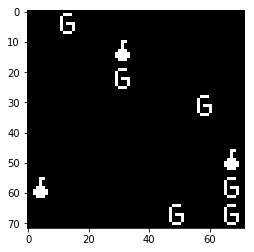

Episode 100 : 50.34000000000002  (temperature 1.0)
Episode 200 : 58.000000000000014  (temperature 0.8)
Episode 300 : 60.79999999999999  (temperature 0.6000000000000001)
Episode 400 : 59.00000000000001  (temperature 0.4000000000000001)
Episode 500 : 65.49000000000001  (temperature 0.20000000000000007)
Episode 600 : 74.47000000000001  (temperature 5.551115123125783e-17)
Episode 700 : 78.10000000000001  (temperature 0.0)
Episode 800 : 84.55999999999996  (temperature 0.0)
Episode 900 : 86.51000000000002  (temperature 0.0)
Episode 1000 : 87.49999999999996  (temperature 0.0)
Episode 100 : 55.910000000000025  (temperature 1.0)
Episode 200 : 54.59  (temperature 0.8)
Episode 300 : 58.68000000000001  (temperature 0.6000000000000001)
Episode 400 : 63.07  (temperature 0.4000000000000001)
Episode 500 : 64.88000000000001  (temperature 0.20000000000000007)
Episode 600 : 73.97  (temperature 5.551115123125783e-17)
Episode 700 : 79.06999999999996  (temperature 0.0)
Episode 800 : 84.05999999999999  (temp

In [51]:
def get_bomb_pattern():
    return np.array([
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]
    ])


def get_coin_pattern():
    return np.array([
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]
    ])


def render(image, bomb_pattern, coin_pattern):
    init_h, init_w = image.shape
    scale_h, scale_w = bomb_pattern.shape
    h = init_h * scale_h
    w = init_w * scale_w
    magnified = np.zeros((h, w), 'uint8')
    for i in range(init_h):
        for j in range(init_w):
            x = scale_h * i
            y = scale_w * j
            if image[i][j] > 0:
                magnified[x:x+scale_h,y:y+scale_w] = coin_pattern
            elif image[i][j] < 0:
                magnified[x:x+scale_h,y:y+scale_w] = bomb_pattern
    return magnified


def show_maze(territory: np.ndarray):
    image = render(territory, get_bomb_pattern(), get_coin_pattern()) * 255
    image = Image.fromarray(image, 'L')
    plt.imshow(image)
    plt.show()
    

def run_episode(env, agent):
    total_reward = 0.
    env.reset()
    while not env.is_done():
        total_reward += agent.step(env)
    return total_reward


class RunningAverage:
    def __init__(self):
        self.average = 0.
        self.count = 0
    
    def add(self, value):
        self.average += 1 / (self.count + 1) * (value - self.average)
        self.count += 1
    
    def reset(self):
        self.average = 0.
        self.count = 0
    
    def __call__(self):
        return self.average


def train_q_agent(env, agent):
    running_average = RunningAverage()
    for episode in range(1, 1001):
        reward = run_episode(env, agent)
        running_average.add(reward)
        
        if episode % 100 == 0:
            print("Episode", episode, ":", running_average(), " (temperature " + str(agent.temperature) + ")")
            agent.temperature_decrease(0.2)
            running_average.reset()


env = FindYourWayEnv.create_random(height=8, width=8, bombs=3, coins=5)
slippery_env = SlipperyFindYourWayEnv(env.territory, slip_prob=0.2)
show_maze(env.territory)
train_q_agent(env=env, agent=QAgent())
train_q_agent(env=slippery_env, agent=QAgent())